In [1]:
import numpy as np
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers, models
from collections import deque
import matplotlib.pyplot as plt
import random
import time
import cv2

In [2]:
env = gym.make("CarRacing-v2", domain_randomize = False, continuous = False, render_mode = "rgb_array")

#np.random.seed(77)
tf.random.set_seed(77)
#epsilon = .99
epsilon = 0.7660431281249999

In [3]:
def create_cnn_model(action_space):
    model = tf.keras.Sequential([
        layers.Conv2D(16, (3, 3), activation = "relu", input_shape = (64, 64, 3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(16, (3, 3), activation = "relu"),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(action_space, activation='softmax')
    ])
    return model

def imagePrep(image):
    image = image / 255.0
    image = tf.image.resize(image, (64, 64))
    return image

class experience_buffer:
    def __init__(self, buffer_size = 10000):
        self.buffer = deque(maxlen = buffer_size)
        
    def add_experience(self, experience):
        self.buffer.append(experience)

    def sample_batch(self, batch_size):
        return random.sample(self.buffer, batch_size)

In [4]:
def custom_reward(action, reward):
    reward_scalar = 1.0
    racing_dict = {
        0: "do nothing",
        1: "steer left",
        2: "steer right",
        3: "gas",
        4: "brake"
    }
    if reward > 0:
        if racing_dict[action] == "gas":
            reward_scalar = 3.0
    elif racing_dict[action] == "steer right":
        reward_scalar = 1
    elif racing_dict[action] == "steer left":
        reward_scalar = 1
    elif racing_dict[action] == "brake":
        reward_scalar = .5
    elif racing_dict[action] == "do nothing":
        reward_scalar = 1
    return reward_scalar * reward

In [5]:
def train_agent():
    racingDict = {
        0: "do nothing",
        1: "steer left",
        2: "steer right",
        3: "gas",
        4: "brake"
    }

    
    gamma = 0.99
    global epsilon
    epsilon_min = 0.01
    epsilon_decay = 0.95
    batch_size = 5
    buffer_size = 1000
    num_episodes = 100
    num_steps = 100
    conditional_batch_thresh = 0.7
    
    action_space = env.action_space.n
    #create the overall model
    model = create_cnn_model(action_space)
    #create the training temporary predictive model
    target_model = create_cnn_model(action_space)
    
    #attempt to load previous weights for warm load
    try:
        model.load_weights("C:/Users/ethan/model_weights.h5")
        target_model.set_weights(model.get_weights())
    except:
        print("error")
    
    #make the optimizer and buffer
    optimizer = tf.keras.optimizers.Adam(learning_rate = .001)
    model.compile(optimizer=optimizer, loss='mse')
    
    exp_buffer = experience_buffer(buffer_size)
    
    for episode in range(num_episodes):
        state, _ = env.reset(seed = 77)
        state = imagePrep(state)
        state = np.expand_dims(state, axis = 0)
        
        total_reward = 0
        
        for step in range(num_steps):
            #epsilon-greedy logic
            if np.random.rand() < epsilon:
                action = np.random.choice(action_space)
                print("explore")
            else:
                q_values = model.predict(state)
                print("exploit")
                print(q_values)
                action = np.argmax(q_values)
                
            print(racingDict[action])
            s_prime, reward, done, trunc, _ = env.step(action);
            s_prime = imagePrep(s_prime)
            s_prime = np.expand_dims(s_prime, axis = 0)
            
            reward = custom_reward(action, reward)
            
            if np.random.rand() < conditional_batch_thresh:
                if len(exp_buffer.buffer) > batch_size:
                    batch = exp_buffer.sample_batch(batch_size)
                    for state_b, action_b, reward_b, s_prime_b, done_b in batch:
                        target = custom_reward(action_b, reward_b)
                        if not done_b:
                            target += gamma * np.amax(target_model.predict(s_prime_b)[0])

                        target_f = model.predict(state_b)
                        target_f[0][action_b] = target

                        model.fit(state_b, target_f, epochs = 1, verbose = 0);
            else:
                target = custom_reward(action, reward)
                if not done:
                    target += gamma * np.amax(target_model.predict(s_prime)[0])
                
                target_f = model.predict(state)
                target_f[0][action] = target
                
                model.fit(state, target_f, epochs = 1, verbose = 0)
                
            exp_buffer.add_experience((state, action, reward, s_prime, done))
            
            state = s_prime
            total_reward += reward
            
            if done:
                break
            print(total_reward)
            model.save_weights('model_weights.h5')
            
        if episode % 10 == 0:
            target_model.set_weights(model.get_weights())
            
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
            
        model.save_weights('model_weights.h5')
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon}")

In [ ]:
train_agent()

1/1 [==============================] - 0s 102ms/step
exploit
[[1.5259243e-03 6.6491677e-03 2.4290165e-04 9.9030089e-01 1.2811419e-03]]
gas
20.75263157894737
explore
steer left
20.65263157894737
1/1 [==============================] - 0s 16ms/step
exploit
[[0.14449449 0.1775204  0.00855132 0.42898303 0.24045075]]
gas
20.55263157894737
explore
steer right
1/1 [==============================] - 0s 15ms/step
20.45263157894737
1/1 [==============================] - 0s 16ms/step
exploit
[[0.2290142  0.14391269 0.02392115 0.301861   0.30129102]]
gas
1/1 [==============================] - 0s 15ms/step
20.352631578947367
1/1 [==============================] - 0s 16ms/step
exploit
[[0.27414906 0.14018069 0.04262311 0.26035234 0.28269482]]
brake
20.302631578947366
explore
do nothing
1/1 [==============================] - 0s 16ms/step
20.20263157894737
explore
do nothing
1/1 [==============================] - 0s 15ms/step
20.102631578947367
explore
do nothing
1/1 [==============================] - 

1/1 [==============================] - 0s 16ms/step
19.052631578947356
explore
do nothing
1/1 [==============================] - 0s 17ms/step
18.952631578947354
explore
do nothing
1/1 [==============================] - 0s 14ms/step
18.852631578947353
explore
do nothing
1/1 [==============================] - 0s 15ms/step
18.75263157894735
explore
brake
1/1 [==============================] - 0s 15ms/step
18.70263157894735
explore
gas
1/1 [==============================] - 0s 15ms/step
18.602631578947353
explore
steer right
1/1 [==============================] - 0s 15ms/step
18.50263157894735
explore
steer left
1/1 [==============================] - 0s 15ms/step
18.40263157894735
1/1 [==============================] - 0s 16ms/step
exploit
[[0.1487861  0.23606156 0.162045   0.18602228 0.26708502]]
brake
1/1 [==============================] - 0s 14ms/step
18.35263157894735
1/1 [==============================] - 0s 16ms/step
exploit
[[0.15126027 0.23421817 0.16374543 0.18640359 0.26437253]]


1/1 [==============================] - 0s 14ms/step
17.352631578947335
explore
brake
1/1 [==============================] - 0s 13ms/step
17.302631578947334
explore
gas
1/1 [==============================] - 0s 15ms/step
17.202631578947333
explore
steer left
1/1 [==============================] - 0s 16ms/step
17.10263157894733
explore
steer right
1/1 [==============================] - 0s 16ms/step
17.00263157894733
explore
do nothing
1/1 [==============================] - 0s 15ms/step
16.90263157894733
1/1 [==============================] - 0s 15ms/step
exploit
[[0.16911483 0.2228798  0.17550904 0.19169779 0.24079856]]
brake
1/1 [==============================] - 0s 16ms/step
16.852631578947328
explore
steer right
1/1 [==============================] - 0s 17ms/step
16.752631578947327
explore
brake
1/1 [==============================] - 0s 16ms/step
16.702631578947326
explore
steer right
1/1 [==============================] - 0s 15ms/step
16.602631578947324
explore
steer left
1/1 [======

1/1 [==============================] - 0s 17ms/step
15.902631578947316
explore
steer right
1/1 [==============================] - 0s 19ms/step
15.802631578947317
explore
do nothing
1/1 [==============================] - 0s 17ms/step
15.702631578947317
explore
brake
1/1 [==============================] - 0s 17ms/step
15.652631578947316
explore
gas
1/1 [==============================] - 0s 16ms/step
15.552631578947317
explore
brake
1/1 [==============================] - 0s 16ms/step
15.502631578947316
explore
do nothing
1/1 [==============================] - 0s 15ms/step
15.402631578947316
explore
steer left
1/1 [==============================] - 0s 15ms/step
15.302631578947317
explore
brake
1/1 [==============================] - 0s 15ms/step
15.252631578947316
1/1 [==============================] - 0s 16ms/step
exploit
[[0.1784742  0.21074633 0.1687604  0.19560643 0.24641265]]
brake
1/1 [==============================] - 0s 16ms/step
15.202631578947315
explore
do nothing
1/1 [==========

1/1 [==============================] - 0s 14ms/step
14.502631578947312
1/1 [==============================] - 0s 16ms/step
exploit
[[0.15491357 0.21589766 0.19580767 0.18448044 0.24890062]]
brake
1/1 [==============================] - 0s 17ms/step
14.452631578947312
1/1 [==============================] - 0s 15ms/step
exploit
[[0.15667416 0.21639964 0.19350849 0.18503864 0.24837905]]
brake
1/1 [==============================] - 0s 15ms/step
14.402631578947311
1/1 [==============================] - 0s 19ms/step
exploit
[[0.16330826 0.2181399  0.1858402  0.18599696 0.24671471]]
brake
1/1 [==============================] - 0s 15ms/step
14.35263157894731
explore
do nothing
1/1 [==============================] - 0s 17ms/step
14.25263157894731
explore
do nothing
1/1 [==============================] - 0s 17ms/step
14.152631578947311
explore
do nothing
1/1 [==============================] - 0s 17ms/step
14.052631578947311
1/1 [==============================] - 0s 16ms/step
exploit
[[0.17376746 

1/1 [==============================] - 0s 15ms/step
16.41140350877187
1/1 [==============================] - 0s 17ms/step
exploit
[[0.12322523 0.21606383 0.13745104 0.27371857 0.24954131]]
gas
1/1 [==============================] - 0s 16ms/step
16.311403508771868
1/1 [==============================] - 0s 15ms/step
exploit
[[0.15172465 0.2254957  0.13476789 0.1591078  0.32890397]]
brake
1/1 [==============================] - 0s 16ms/step
16.261403508771867
explore
steer right
1/1 [==============================] - 0s 16ms/step
16.161403508771865
Episode: 1, Total Reward: 16.161403508771865, Epsilon: 0.7277409717187499
1/1 [==============================] - 0s 15ms/step
exploit
[[2.5058156e-05 1.0455207e-04 6.4492597e-06 9.9983931e-01 2.4627821e-05]]
gas
1/1 [==============================] - 0s 15ms/step
20.75263157894737
explore
steer left
1/1 [==============================] - 0s 16ms/step
20.65263157894737
explore
steer right
1/1 [==============================] - 0s 14ms/step
20.552

1/1 [==============================] - 0s 15ms/step
19.552631578947363
explore
steer right
1/1 [==============================] - 0s 16ms/step
19.45263157894736
explore
do nothing
1/1 [==============================] - 0s 16ms/step
19.35263157894736
explore
gas
1/1 [==============================] - 0s 15ms/step
19.25263157894736
explore
steer right
1/1 [==============================] - 0s 16ms/step
19.152631578947357
explore
steer left
1/1 [==============================] - 0s 15ms/step
19.052631578947356
1/1 [==============================] - 0s 16ms/step
exploit
[[0.19583967 0.19278015 0.13113968 0.20792077 0.2723197 ]]
brake
1/1 [==============================] - 0s 15ms/step
19.002631578947355
explore
gas
1/1 [==============================] - 0s 15ms/step
18.902631578947357
1/1 [==============================] - 0s 15ms/step
exploit
[[0.1941732  0.19185789 0.1386928  0.19980237 0.27547377]]
brake
1/1 [==============================] - 0s 15ms/step
18.852631578947356
explore
do n

1/1 [==============================] - 0s 15ms/step
18.202631578947354
explore
gas
1/1 [==============================] - 0s 15ms/step
18.102631578947353
1/1 [==============================] - 0s 15ms/step
exploit
[[0.19585605 0.18660292 0.15783261 0.1945596  0.26514876]]
brake
1/1 [==============================] - 0s 15ms/step
18.052631578947352
explore
gas
1/1 [==============================] - 0s 15ms/step
17.95263157894735
1/1 [==============================] - 0s 15ms/step
exploit
[[0.20819807 0.18174127 0.14413281 0.20583096 0.26009694]]
brake
1/1 [==============================] - 0s 15ms/step
17.90263157894735
1/1 [==============================] - 0s 15ms/step
exploit
[[0.20055844 0.18311197 0.15212074 0.19636714 0.26784176]]
brake
1/1 [==============================] - 0s 15ms/step
17.85263157894735
explore
do nothing
1/1 [==============================] - 0s 15ms/step
17.752631578947348
1/1 [==============================] - 0s 15ms/step
exploit
[[0.17146826 0.1952857  0.14

1/1 [==============================] - 0s 15ms/step
17.002631578947337
explore
steer right
1/1 [==============================] - 0s 15ms/step
16.902631578947336
explore
gas
1/1 [==============================] - 0s 15ms/step
16.802631578947334
1/1 [==============================] - 0s 15ms/step
exploit
[[0.1625089  0.19400539 0.16349326 0.18445772 0.29553473]]
brake
1/1 [==============================] - 0s 15ms/step
16.752631578947334
explore
steer right
1/1 [==============================] - 0s 15ms/step
16.652631578947332
explore
do nothing
1/1 [==============================] - 0s 15ms/step
16.55263157894733
explore
gas
1/1 [==============================] - 0s 16ms/step
16.45263157894733
explore
do nothing
1/1 [==============================] - 0s 16ms/step
16.352631578947328
explore
gas
1/1 [==============================] - 0s 15ms/step
16.252631578947327
explore
brake
1/1 [==============================] - 0s 17ms/step
16.202631578947326
explore
do nothing
1/1 [===============

1/1 [==============================] - 0s 15ms/step
18.961403508771884
explore
steer left
1/1 [==============================] - 0s 16ms/step
18.861403508771886
explore
steer left
1/1 [==============================] - 0s 15ms/step
18.761403508771885
explore
brake
1/1 [==============================] - 0s 14ms/step
18.711403508771884
explore
gas
1/1 [==============================] - 0s 15ms/step
18.611403508771883
explore
gas
1/1 [==============================] - 0s 16ms/step
18.51140350877188
explore
gas
1/1 [==============================] - 0s 15ms/step
18.41140350877188
explore
steer right
1/1 [==============================] - 0s 15ms/step
18.31140350877188
explore
brake
1/1 [==============================] - 0s 16ms/step
18.261403508771878
explore
steer left
1/1 [==============================] - 0s 15ms/step
18.161403508771876
1/1 [==============================] - 0s 16ms/step
exploit
[[0.1744294  0.20030747 0.13915908 0.14946713 0.33663687]]
brake
1/1 [======================

1/1 [==============================] - 0s 16ms/step
17.261403508771863
explore
gas
1/1 [==============================] - 0s 17ms/step
17.161403508771862
explore
steer right
1/1 [==============================] - 0s 16ms/step
17.06140350877186
1/1 [==============================] - 0s 15ms/step
exploit
[[0.15717964 0.1919772  0.08118791 0.20850565 0.36114964]]
brake
1/1 [==============================] - 0s 16ms/step
17.01140350877186
explore
brake
1/1 [==============================] - 0s 15ms/step
16.96140350877186
explore
do nothing
1/1 [==============================] - 0s 15ms/step
16.861403508771858
explore
do nothing
1/1 [==============================] - 0s 15ms/step
16.761403508771856
explore
brake
1/1 [==============================] - 0s 15ms/step
16.711403508771856
explore
steer right
1/1 [==============================] - 0s 15ms/step
16.611403508771854
explore
gas
1/1 [==============================] - 0s 15ms/step
16.511403508771853
explore
brake
1/1 [===================

1/1 [==============================] - 0s 15ms/step
6.517543859649124
explore
steer right
1/1 [==============================] - 0s 15ms/step
6.4175438596491245
1/1 [==============================] - 0s 16ms/step
exploit
[[0.10917781 0.23117203 0.24337555 0.16404882 0.2522258 ]]
brake
1/1 [==============================] - 0s 16ms/step
6.367543859649125
explore
do nothing
1/1 [==============================] - 0s 16ms/step
6.267543859649125
explore
steer left
1/1 [==============================] - 0s 15ms/step
6.167543859649125
explore
steer left
1/1 [==============================] - 0s 19ms/step
6.067543859649126
1/1 [==============================] - 0s 16ms/step
exploit
[[0.1635513  0.22842053 0.18902335 0.15131927 0.26768553]]
brake
1/1 [==============================] - 0s 16ms/step
6.017543859649126
explore
do nothing
1/1 [==============================] - 0s 16ms/step
5.917543859649126
explore
steer left
1/1 [==============================] - 0s 15ms/step
5.817543859649127
expl

1/1 [==============================] - 0s 15ms/step
exploit
[[0.17583947 0.18219873 0.17994824 0.18134873 0.2806648 ]]
brake
1/1 [==============================] - 0s 15ms/step
5.0175438596491295
1/1 [==============================] - 0s 15ms/step
exploit
[[0.1752034  0.18162408 0.18176326 0.18225968 0.27914953]]
brake
1/1 [==============================] - 0s 15ms/step
4.96754385964913
explore
do nothing
1/1 [==============================] - 0s 16ms/step
4.86754385964913
explore
steer left
1/1 [==============================] - 0s 16ms/step
4.76754385964913
explore
brake
1/1 [==============================] - 0s 16ms/step
4.717543859649131
1/1 [==============================] - 0s 15ms/step
exploit
[[0.15305106 0.17933805 0.1250347  0.12281685 0.41975936]]
brake
1/1 [==============================] - 0s 14ms/step
4.667543859649131
1/1 [==============================] - 0s 16ms/step
exploit
[[0.15224957 0.17906795 0.12301804 0.12088084 0.42478362]]
brake
1/1 [=========================

1/1 [==============================] - 0s 15ms/step
3.9175438596491325
explore
brake
1/1 [==============================] - 0s 17ms/step
3.8675438596491327
explore
gas
1/1 [==============================] - 0s 16ms/step
3.7675438596491326
1/1 [==============================] - 0s 16ms/step
exploit
[[0.15513423 0.1873044  0.11897577 0.11031224 0.42827338]]
brake
1/1 [==============================] - 0s 15ms/step
3.7175438596491324
explore
steer left
1/1 [==============================] - 0s 18ms/step
3.6175438596491323
1/1 [==============================] - 0s 15ms/step
exploit
[[0.1647633  0.1896893  0.12059387 0.11805436 0.40689915]]
brake
1/1 [==============================] - 0s 15ms/step
3.567543859649132
explore
steer right
1/1 [==============================] - 0s 16ms/step
3.467543859649132
explore
steer right
1/1 [==============================] - 0s 16ms/step
3.367543859649132
explore
steer left
1/1 [==============================] - 0s 18ms/step
3.2675438596491317
explore
ga

1/1 [==============================] - 0s 16ms/step
2.267543859649131
1/1 [==============================] - 0s 17ms/step
exploit
[[0.19111674 0.20089644 0.14706603 0.1680472  0.29287365]]
brake
1/1 [==============================] - 0s 17ms/step
2.217543859649131
1/1 [==============================] - 0s 16ms/step
exploit
[[0.17876323 0.2063131  0.1440335  0.16309015 0.30779997]]
brake
1/1 [==============================] - 0s 15ms/step
2.167543859649131
explore
steer left
1/1 [==============================] - 0s 16ms/step
2.067543859649131
explore
gas
1/1 [==============================] - 0s 14ms/step
1.967543859649131
explore
do nothing
1/1 [==============================] - 0s 17ms/step
1.867543859649131
explore
gas
1/1 [==============================] - 0s 15ms/step
1.7675438596491309
explore
gas
1/1 [==============================] - 0s 16ms/step
1.6675438596491308
explore
steer left
1/1 [==============================] - 0s 16ms/step
1.5675438596491307
explore
brake
1/1 [=====

1/1 [==============================] - 0s 17ms/step
0.7175438596491304
1/1 [==============================] - 0s 18ms/step
exploit
[[0.16939458 0.2027198  0.17690895 0.18253599 0.26844063]]
brake
1/1 [==============================] - 0s 14ms/step
0.6675438596491303
1/1 [==============================] - 0s 15ms/step
exploit
[[0.17135973 0.20110534 0.16717224 0.16838275 0.2919799 ]]
brake
1/1 [==============================] - 0s 15ms/step
0.6175438596491303
1/1 [==============================] - 0s 17ms/step
exploit
[[0.17504036 0.19517168 0.13676682 0.13944283 0.35357824]]
brake
1/1 [==============================] - 0s 18ms/step
0.5675438596491302
explore
gas
1/1 [==============================] - 0s 15ms/step
0.46754385964913014
explore
steer left
1/1 [==============================] - 0s 16ms/step
0.36754385964913006
explore
brake
1/1 [==============================] - 0s 16ms/step
0.31754385964913
explore
brake
1/1 [==============================] - 0s 16ms/step
0.267543859649129

1/1 [==============================] - 0s 15ms/step
2.876315789473691
1/1 [==============================] - 0s 16ms/step
exploit
[[0.18996327 0.18979669 0.14658621 0.15528232 0.31837147]]
brake
1/1 [==============================] - 0s 15ms/step
2.826315789473691
Episode: 3, Total Reward: 2.826315789473691, Epsilon: 0.6567862269761716
explore
brake
1/1 [==============================] - 0s 16ms/step
6.917543859649123
1/1 [==============================] - 0s 18ms/step
exploit
[[0.00170273 0.62689483 0.01285045 0.23415239 0.12439966]]
steer left
1/1 [==============================] - 0s 16ms/step
6.817543859649123
explore
do nothing
1/1 [==============================] - 0s 15ms/step
6.7175438596491235
explore
gas
1/1 [==============================] - 0s 15ms/step
6.617543859649124
explore
brake
1/1 [==============================] - 0s 16ms/step
6.567543859649124
1/1 [==============================] - 0s 16ms/step
exploit
[[0.2103847  0.20192647 0.10345014 0.08237635 0.40186235]]
bra

1/1 [==============================] - 0s 16ms/step
5.667543859649127
1/1 [==============================] - 0s 15ms/step
exploit
[[0.18651275 0.17869005 0.16966909 0.14601474 0.31911334]]
brake
1/1 [==============================] - 0s 15ms/step
5.617543859649127
explore
gas
1/1 [==============================] - 0s 15ms/step
5.517543859649128
1/1 [==============================] - 0s 16ms/step
exploit
[[0.1856816  0.17868651 0.17780888 0.14970292 0.30812013]]
brake
1/1 [==============================] - 0s 16ms/step
5.467543859649128
1/1 [==============================] - 0s 14ms/step
exploit
[[0.17337152 0.18481016 0.1723762  0.14141051 0.3280316 ]]
brake
1/1 [==============================] - 0s 16ms/step
5.417543859649128
explore
brake
1/1 [==============================] - 0s 16ms/step
5.367543859649128
1/1 [==============================] - 0s 15ms/step
exploit
[[0.17268836 0.1847153  0.1758686  0.1422959  0.32443187]]
brake
1/1 [==============================] - 0s 17ms/step
5.

1/1 [==============================] - 0s 15ms/step
4.51754385964913
1/1 [==============================] - 0s 16ms/step
exploit
[[0.17072646 0.18319803 0.19137011 0.14779732 0.30690813]]
brake
1/1 [==============================] - 0s 15ms/step
4.467543859649131
1/1 [==============================] - 0s 15ms/step
exploit
[[0.17003289 0.18292218 0.19348049 0.14845458 0.3051099 ]]
brake
1/1 [==============================] - 0s 16ms/step
4.417543859649131
1/1 [==============================] - 0s 15ms/step
exploit
[[0.16960657 0.18255249 0.19489393 0.14943534 0.30351165]]
brake
1/1 [==============================] - 0s 16ms/step
4.367543859649131
explore
steer right
1/1 [==============================] - 0s 16ms/step
4.26754385964913
explore
brake
1/1 [==============================] - 0s 20ms/step
4.217543859649131
explore
steer right
1/1 [==============================] - 0s 15ms/step
4.11754385964913
explore
do nothing
1/1 [==============================] - 0s 16ms/step
4.01754385964

1/1 [==============================] - 0s 16ms/step
3.617543859649131
1/1 [==============================] - 0s 16ms/step
exploit
[[0.16839112 0.1840947  0.19697128 0.15203997 0.2985029 ]]
brake
1/1 [==============================] - 0s 16ms/step
3.567543859649131
explore
steer right
1/1 [==============================] - 0s 15ms/step
3.467543859649131
1/1 [==============================] - 0s 15ms/step
exploit
[[0.1821221  0.17546132 0.2085199  0.16812553 0.2657712 ]]
brake
1/1 [==============================] - 0s 15ms/step
3.4175438596491308
explore
steer left
1/1 [==============================] - 0s 15ms/step
3.3175438596491307
explore
steer left
1/1 [==============================] - 0s 15ms/step
3.2175438596491306
explore
do nothing
1/1 [==============================] - 0s 15ms/step
3.1175438596491305
explore
gas
1/1 [==============================] - 0s 16ms/step
3.0175438596491304
explore
gas
1/1 [==============================] - 0s 17ms/step
2.9175438596491303
explore
brake

1/1 [==============================] - 0s 24ms/step
[[0.065161   0.0102598  0.00152342 0.9203856  0.00267023]]
3
3.4087719298245602


KeyboardInterrupt: 

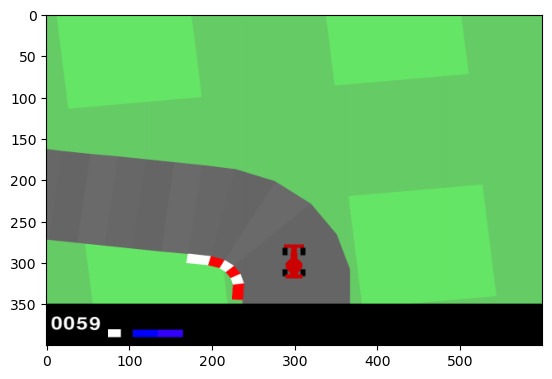

In [22]:
from IPython import display
import matplotlib.pyplot as plt
import time


env = gym.make("CarRacing-v2", domain_randomize=False, continuous=False, render_mode="rgb_array")
model = create_cnn_model(env.action_space.n)
model.load_weights("C:/Users/ethan/model_weights.h5")

done = False
trunc = False
state, _ = env.reset(seed=77)

count = 0

fig, ax = plt.subplots()
img = ax.imshow(env.render())
display.display(fig)
display.clear_output(wait=True)

while not (done or trunc):
    img.set_data(env.render())
    display.display(fig)
    display.clear_output(wait=True)

    state = imagePrep(state)
    state = state[np.newaxis, ...]
    if count > 15:
        q_values = model.predict(state)
        print(q_values)
        action = np.argmax(q_values)
        print(action)
    else:
        action = 3
        count += 1

    next_state, reward, done, trunc, _ = env.step(action)
    print(reward)

    state = next_state
    time.sleep(0.02)

env.close()

In [27]:
env = gym.make("CarRacing-v2", domain_randomize=False, continuous=False, render_mode = "human")

model = create_cnn_model(env.action_space.n)
model.load_weights("C:/Users/ethan/model_weights.h5")

state = env.reset(seed = 77)
# Your interaction loop here
done = False
trunc = False
state, _ = env.reset(seed=77)

count = 16
while not (done or trunc):
    #env.render()

    state = imagePrep(state)
    state = state[np.newaxis, ...]
    
    q_values = model.predict(state)
    action = np.argmax(q_values)
        
    next_state, reward, done, trunc, _ = env.step(action)
    print(custom_reward(action, reward))

    state = next_state
    time.sleep(0.02)

env.close()

1/1 [==============================] - 0s 66ms/step
6.917543859649123
1/1 [==============================] - 0s 22ms/step
-0.09999999999999964
1/1 [==============================] - 0s 23ms/step
-0.09999999999999964
1/1 [==============================] - 0s 21ms/step
-0.09999999999999964
1/1 [==============================] - 0s 22ms/step
-0.09999999999999964
1/1 [==============================] - 0s 21ms/step
-0.09999999999999964
1/1 [==============================] - 0s 22ms/step
-0.09999999999999964
1/1 [==============================] - 0s 21ms/step
-0.09999999999999964
1/1 [==============================] - 0s 22ms/step
-0.09999999999999964
1/1 [==============================] - 0s 21ms/step
-0.09999999999999964
1/1 [==============================] - 0s 22ms/step
-0.09999999999999964
1/1 [==============================] - 0s 23ms/step
-0.09999999999999964
1/1 [==============================] - 0s 20ms/step
-0.09999999999999964
1/1 [==============================] - 0s 26ms/step
-0

KeyboardInterrupt: 